# High Level Pipline for GCN and GNODE for Brain State Identification

## Pipeline Overview

### 1.1 Adjacency Matrix Generation ---> **2.1 Unsupervised GCN** ---> 3.1 Supervised MLP

### 1.1 Adjacency Matrix Generation ---> **2.2 Unsupervised GNODE** ---> 3.1 Supervised MLP

[Introduction and overview should be written here]

#### High Level Classes imported:

DataManager.py DataManagerUtil.py : [insert description here]

GCN.py GCNutil.py : [insert description here]

GDE.py GDEutil.py GDEsolvers.py : [insert description here]

MLP.py : [insert description here]

In [1]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

#### Dataset:

[A short description here]

name: X_test
shape: (640, 35, 2649)
-----------------------
name: X_train
shape: (640, 35, 2564)
-----------------------
name: clip_sizes_test
shape: (2, 102)
-----------------------
name: clip_sizes_train
shape: (2, 101)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 2649)
-----------------------
name: sel_win_nums_train
shape: (1, 2564)
-----------------------
name: soz_ch_ids
shape: (7, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 2649)
-----------------------
name: y_train
shape: (1, 2564)
-----------------------
print sample EGG signal from one node:


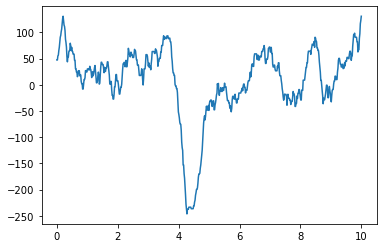

In [26]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_273.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [32]:
#OPTIONAL: Shuffle the dataset
variables, indices = shuffle_train_test(variables, train_ratio = 0.5, print_summary = True)

KeyboardInterrupt: 

In [101]:
#OPTIONAL: Remove Overlapping Parts
variables = remove_overlap(variables)

In [5]:
#save the shuffled indices
np.save("datasets/indices_253.npy",indices)

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 1.1 Adjacency Matrix Generation

[short description here]

##### 1.1.1 Create the datamanager object that computes the covariance matrix for you.

In [27]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [4]:
#reduce redundant nodes
#from DataManager import get_label_variance as glv
#print(glv(dm.X_train, dm.Y_train))
#print(np.argsort(glv(dm.X_train, dm.Y_train)))
print(dm)
#dm.apply_dvariance_filter(30)
print(dm)

X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)
X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)


In [5]:
#from DataManager import extend_identity as extend_identity
#print(extend_identity(2500,16), extend_identity(2500,16).shape)
print(dm)
#dm.resize_clip(64)
print(dm)

X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)
X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)


##### 1.1.2 Visualize the mean covariance matrix across all training samples

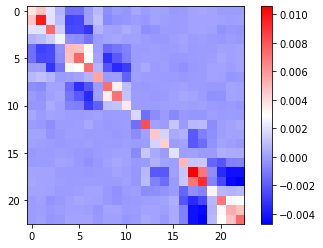

In [44]:
show_heat_map(dm.P_avg_train)

##### 1.1.3 Create DAD from dm by setting the threshold n. repeating this untill a desireble "n" value is found.

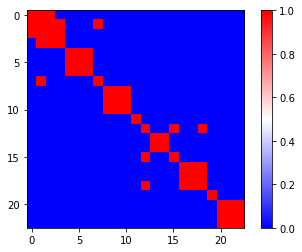

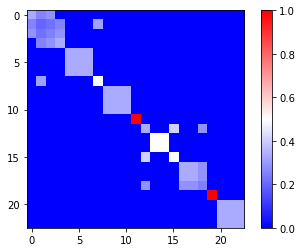

In [46]:
n = 8.5*10**-4
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 2.1 Unsupervised Graph Convolutional Neural Network (GCN)

[short description here]

##### 2.1.1 Declare Parameters for GCN

In [47]:
#create new model
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 512,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
print(GCNparameters)
GCNcheckpoint = {'parameters': GCNparameters}

{'body': 640, 'M': 2472, 'batch_size': 512, 'n_layers': 2, 'num_epochs': 1, 'learning_rate': 0.001, 'weight_decay': 0.005}


##### 2.1.2 Train GCN

In [48]:
#strongly recommand cpu because it's only one epoch training time and CUDA some times run out of memory if you retrain multiple times
device_name = 'cpu'
GCNmodel, GCNcheckpoint = GCNutil.train_GCN(A, X_train, X_test, GCNcheckpoint, device_name = device_name, load = False, print_summary = False)

  0%|          | 0/5 [00:00<?, ?it/s]

device set to cpu


 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

 40%|████      | 2/5 [00:01<00:02,  1.14it/s]

 60%|██████    | 3/5 [00:02<00:01,  1.14it/s]

 80%|████████  | 4/5 [00:03<00:00,  1.12it/s]

100%|██████████| 5/5 [00:04<00:00,  1.13it/s]

Epoch: 1   Batch: 5 of size 512   Train loss: 195.67898559570312   Valid loss: 196.40139770507812


In [49]:
#optional: saving the model
GCNutil.save_ckp(GCNcheckpoint, "models/GCN253_1.pt")

model saved


##### 2.1.3 Visualize some simularity matrices generated by GCN (a visual evaluation and sanity check)

In [50]:
GCNmodel.eval()
test_pred = GCNmodel(torch.from_numpy(X_train[:128, :,:]).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

sample 0   label, 0.0


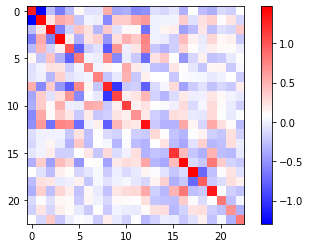

sample 1   label, 0.0


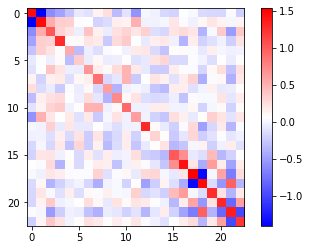

sample 2   label, 0.0


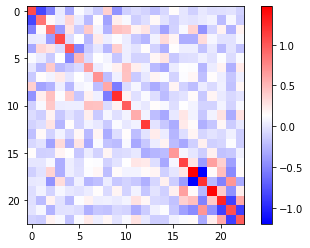

sample 3   label, 0.0


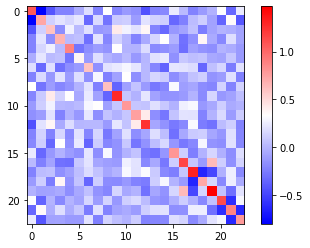

sample 4   label, 1.0


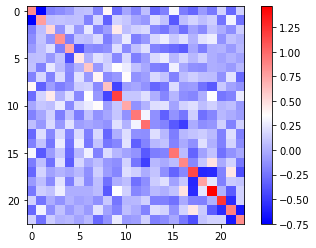

sample 5   label, 1.0


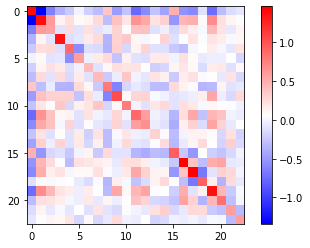

sample 6   label, 1.0


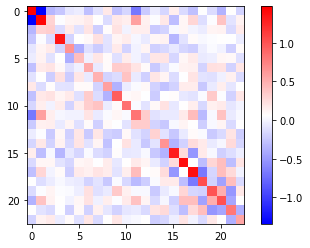

sample 7   label, 1.0


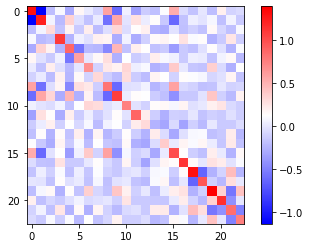

sample 8   label, 1.0


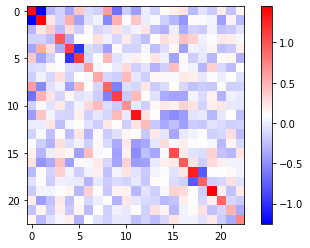

sample 9   label, 1.0


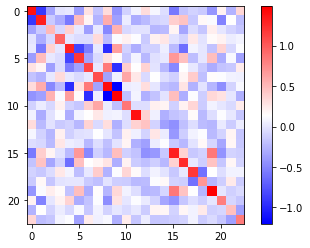

In [51]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 2.1 Unsupervised Graph Neural Ordinary Differential Equations (GNODE)

[short description here]

##### 2.2.1 Declare Parameters for GNODE

In [52]:
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.EF
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEcheckpoint = {'parameters': GDEparameters}

##### 2.2.2 Train GNODE

In [53]:
#strongly recommand cpu because it's only one epoch training time and CUDA some times run out of memory if you retrain multiple times
device_name = 'cpu'
GDEmodel, GDEcheckpoint = GDEutil.train_GDE(A, X_train, X_test, GDEcheckpoint, device_name = device_name, load = False, print_summary = False)

  0%|          | 0/20 [00:00<?, ?it/s]

device set to cpu


  5%|▌         | 1/20 [00:01<00:32,  1.72s/it]

 10%|█         | 2/20 [00:03<00:31,  1.73s/it]

 15%|█▌        | 3/20 [00:05<00:29,  1.74s/it]

 20%|██        | 4/20 [00:07<00:28,  1.75s/it]

 25%|██▌       | 5/20 [00:08<00:26,  1.78s/it]

 30%|███       | 6/20 [00:10<00:24,  1.78s/it]

 35%|███▌      | 7/20 [00:12<00:23,  1.80s/it]

 40%|████      | 8/20 [00:14<00:21,  1.80s/it]

 45%|████▌     | 9/20 [00:16<00:19,  1.79s/it]

 50%|█████     | 10/20 [00:17<00:17,  1.79s/it]

 55%|█████▌    | 11/20 [00:19<00:15,  1.78s/it]

 60%|██████    | 12/20 [00:21<00:14,  1.78s/it]

 65%|██████▌   | 13/20 [00:23<00:12,  1.77s/it]

 70%|███████   | 14/20 [00:24<00:10,  1.76s/it]

 75%|███████▌  | 15/20 [00:26<00:08,  1.76s/it]

 80%|████████  | 16/20 [00:28<00:07,  1.77s/it]

 85%|████████▌ | 17/20 [00:30<00:05,  1.78s/it]

 90%|█████████ | 18/20 [00:31<00:03,  1.78s/it]

 95%|█████████▌| 19/20 [00:33<00:01,  1.78s/it]

100%|██████████| 20/20 [00:34<00:00,  1.72s/it]

Epoch: 1   Batch: 20 of size 128   Train loss: 175.7789764404297   Valid loss: 171.45391845703125


In [54]:
#optional: saving the model
GDEutil.save_ckp(GDEcheckpoint, "models/GDE253_1.pt")

model saved


##### 2.2.3 Visualize some simularity matrices generated by GNODE (a visual evaluation and sanity check)

In [55]:
GDEmodel.eval()
test_pred = GDEmodel(torch.from_numpy(X_train[:128, :,:]).float().to(device_name)).cpu().detach().numpy()

sample 0   label, 0.0


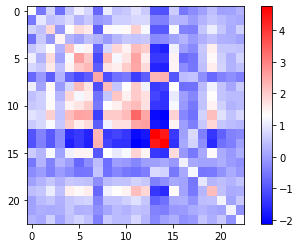

sample 1   label, 0.0


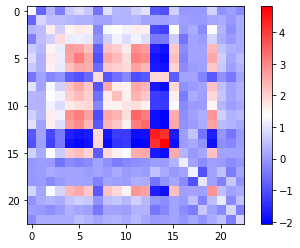

sample 2   label, 0.0


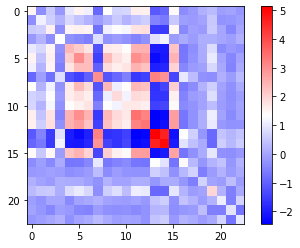

sample 3   label, 0.0


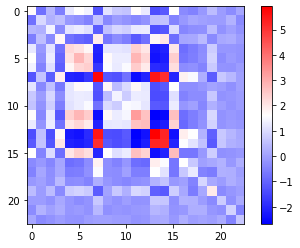

sample 4   label, 1.0


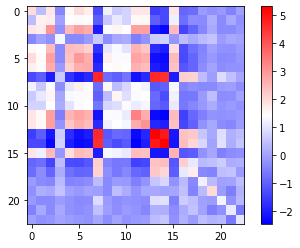

sample 5   label, 1.0


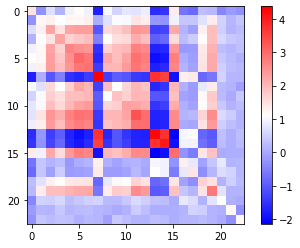

sample 6   label, 1.0


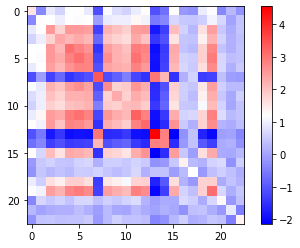

sample 7   label, 1.0


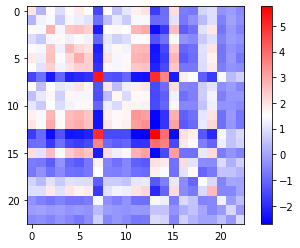

sample 8   label, 1.0


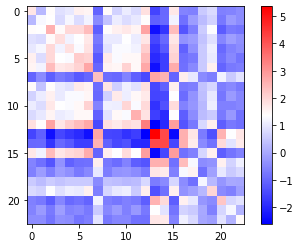

sample 9   label, 1.0


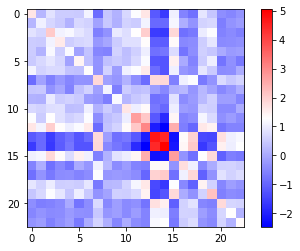

In [56]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

$\;\;\;\;\;\;\;\;\;\;\;\;\;\;$

## 3.1 Supervised Multi-Layer Perceptron (MLP)

[short description here]

##### 3.1.1 Get simularity matrix from GCN and GNODE models

In [57]:
sim_all = {}
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
device_name = 'cpu'

In [29]:
#Get simularity matrix from GCN
GCNmodel.eval()
sim_all["GCN_train"] = GCNmodel(torch.from_numpy(X_train).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()
sim_all["GCN_test"] = GCNmodel(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

In [59]:
#Get simularity matrix from GNODE
GDEmodel.eval()
sim_all["GDE_train"] = GDEmodel(torch.from_numpy(X_train).float().to(device_name)).cpu().detach().numpy()
sim_all["GDE_test"] = GDEmodel(torch.from_numpy(X_test).float().to(device_name)).cpu().detach().numpy()

##### 3.1.2 Visualize the averaged ictal and non-ictal states for the two models

Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


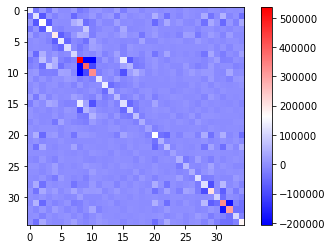

Average Non-Ictal


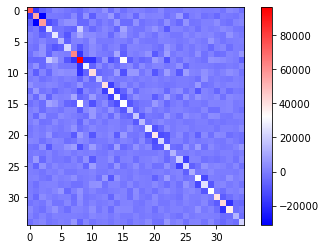

In [30]:
print("Average Ictal and Non-Ictal Simularity Matrix for GCN")
visualize_avg_sim_matrix(dm, sim_all["GCN_train"], sim_all["GCN_test"])

Average Ictal and Non-Ictal Simularity Matrix for GDE
Average ictal


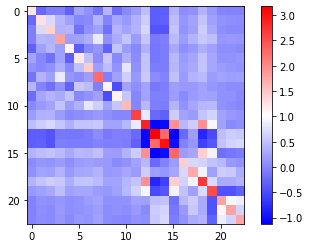

Average Non-Ictal


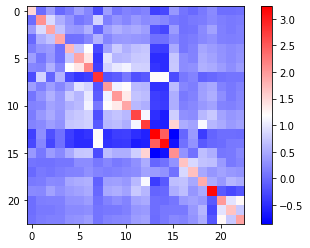

In [61]:
print("Average Ictal and Non-Ictal Simularity Matrix for GDE")
visualize_avg_sim_matrix(dm, sim_all["GDE_train"], sim_all["GDE_test"])

##### 3.1.3 MLP for GCN  

###### Training

In [31]:
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,1], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGCN, _,_, MLPcheckpointGCN = MLP.train_MLP(dm, sim_all["GCN_train"], sim_all["GCN_test"], MLPparametersGCN, acc_fn=MLP.F1, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=630, out_features=630, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=630, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 630]               0
            Linear-2                  [-1, 630]         397,530
              ReLU-3                  [-1, 630]               0
           Dropout-4                  [-1, 630]               0
            Linear-5                    [-1, 1]             631
           Sigmoid-6                    [-1, 1]               0
Total params: 398,161
Trainable params: 398,161
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


 2   Train loss: 8.7798   Train accuracy: 0.0   Val loss: 11.1363   Val accuracy: 0.0    weighted Val loss: 11.1363
Epoch: 3   Train loss: 11.1235   Train accuracy: 0.0   Val loss: 11.1363   Val accuracy: 0.0    weighted Val loss: 11.1363
Epoch: 4   Train loss: 11.0863   Train accuracy: 0.008   Val loss: 11.1363   Val accuracy: 0.0    weighted Val loss: 11.1363
Epoch: 5   Train loss: 8.7798   Train accuracy: 0.0   Val loss: 11.1363   Val accuracy: 0.0    weighted Val loss: 11.1363
Epoch: 6   Train loss: 8.7798   Train accuracy: 0.0   Val loss: 11.1363   Val accuracy: 0.0    weighted Val loss: 11.1363
Epoch: 7   Train loss: 8.817   Train accuracy: 0.0   Val loss: 11.1363   Val accuracy: 0.0    weighted Val loss: 11.1363
Epoch: 8   Train loss: 8.7798   Train accuracy: 0.0   Val loss: 11.1363   Val accuracy: 0.0    weighted Val loss: 11.1363
Epoch: 9   Train loss: 8.7798   Train accuracy: 0.0   Val loss: 11.1363   Val accuracy: 0.0    weighted Val loss: 11.1363
Epoch: 10   Train loss: 8.7

KeyboardInterrupt: 

In [63]:
#optional: save the model
MLP.save_ckp(MLPcheckpointGCN, "models/MLPGCN253_2.pt")

model saved


###### Result

device set to cuda
threshold: 0.05  validation loss: 0.3613 F1 accuracy 0.338 Precision accuracy 0.21 Recall accuracy 0.865 AUC accuracy: 0.807
device set to cuda
threshold: 0.1  validation loss: 0.3613 F1 accuracy 0.388 Precision accuracy 0.256 Recall accuracy 0.798 AUC accuracy: 0.807
device set to cuda
threshold: 0.15  validation loss: 0.3613 F1 accuracy 0.407 Precision accuracy 0.285 Recall accuracy 0.708 AUC accuracy: 0.807
device set to cuda
threshold: 0.2  validation loss: 0.3613 F1 accuracy 0.428 Precision accuracy 0.315 Recall accuracy 0.67 AUC accuracy: 0.807
device set to cuda
threshold: 0.25  validation loss: 0.3613 F1 accuracy 0.44 Precision accuracy 0.337 Recall accuracy 0.635 AUC accuracy: 0.807
device set to cuda
threshold: 0.3  validation loss: 0.3613 F1 accuracy 0.444 Precision accuracy 0.356 Recall accuracy 0.59 AUC accuracy: 0.807
device set to cuda
threshold: 0.35  validation loss: 0.3613 F1 accuracy 0.443 Precision accuracy 0.375 Recall accuracy 0.542 AUC accuracy

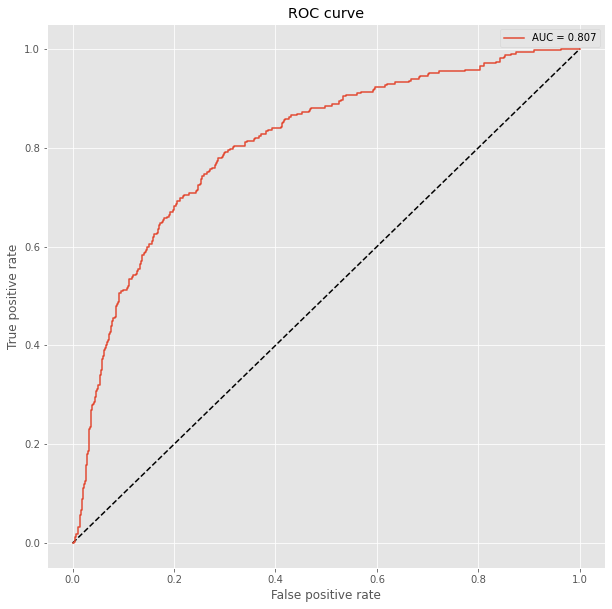

In [71]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGCN, sim_all["GCN_test"], dm, device_name = 'cuda', threshold = t)
MLP.eval_plot_MLP(MLPmodelGCN, sim_all["GCN_test"], dm, device_name = 'cuda')

##### 3.1.2 MLP for GDE

###### Training

In [65]:
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 64], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGDE, _,_, MLPcheckpointGDE = MLP.train_MLP(dm, sim_all["GDE_train"], sim_all["GDE_test"], MLPparametersGDE, acc_fn=MLP.F1, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=276, out_features=4, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 276]               0
            Linear-2                    [-1, 4]           1,108
              ReLU-3                    [-1, 4]               0
           Dropout-4                    [-1, 4]               0
            Linear-5                    [-1, 1]               5
           Sigmoid-6                    [-1, 1]               0
Total params: 1,113
Trainable params: 1,113
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estim

In [66]:
#optional: save the model
MLP.save_ckp(MLPcheckpointGDE, "models/MLPGDE253_1.pt")

model saved


###### Result

device set to cuda
threshold: 0.05  validation loss: 0.3433 F1 accuracy 0.326 Precision accuracy 0.21 Recall accuracy 0.728 AUC accuracy: 0.759
device set to cuda
threshold: 0.1  validation loss: 0.3433 F1 accuracy 0.378 Precision accuracy 0.272 Recall accuracy 0.619 AUC accuracy: 0.759
device set to cuda
threshold: 0.15  validation loss: 0.3433 F1 accuracy 0.424 Precision accuracy 0.356 Recall accuracy 0.526 AUC accuracy: 0.759
device set to cuda
threshold: 0.2  validation loss: 0.3433 F1 accuracy 0.443 Precision accuracy 0.401 Recall accuracy 0.494 AUC accuracy: 0.759
device set to cuda
threshold: 0.25  validation loss: 0.3433 F1 accuracy 0.416 Precision accuracy 0.421 Recall accuracy 0.41 AUC accuracy: 0.759
device set to cuda
threshold: 0.3  validation loss: 0.3433 F1 accuracy 0.385 Precision accuracy 0.429 Recall accuracy 0.349 AUC accuracy: 0.759
device set to cuda
threshold: 0.35  validation loss: 0.3433 F1 accuracy 0.362 Precision accuracy 0.433 Recall accuracy 0.311 AUC accura

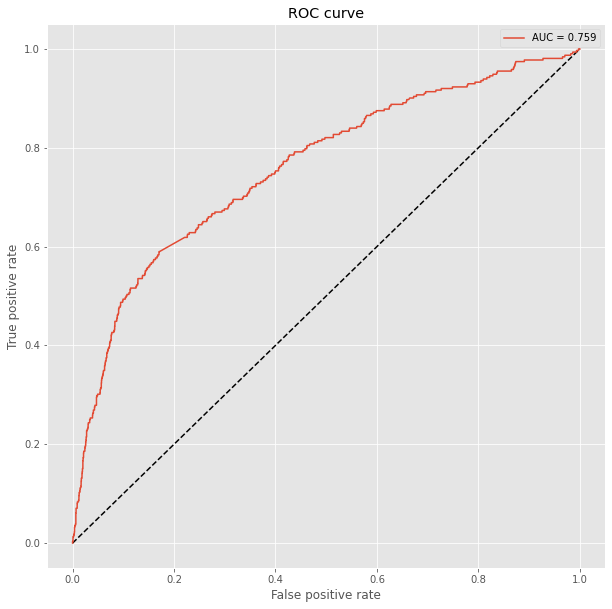

In [69]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGDE, sim_all["GDE_test"], dm, device_name = 'cuda', threshold = t)
MLP.eval_plot_MLP(MLPmodelGDE, sim_all["GDE_test"], dm, device_name = 'cuda')

Questions for Nafiseh:
1. Shuffling the dataset greatly reduces overfitting and improves the accuracy. Can we shuffle the dataset? Is removing the overlapping signals a valid way to shuffle the dataset?
2. Even without shuffling the dataset, removing overlapping signals still greatly improves the validation accuracy. Should we remove the overlapping signal?
3. The built-in AUC metric in Scikit-learn yields a lot higher accuracy than the maximum F-score obatined. Is it normal? What is your AUC accuracy implementation?

In [28]:
def create_adjacency_matrix(X):
        '''
        Input types:
        X: MxNxD Numpy Tensor
        n: float threshold for adjacency matrix

        Returns:
        A: sparse NxN adjacency matrix with thresholding
        P_avg: raw NxN covariance matrix before thresholding
        remove_indices: indices of bad samples that should be removed
        '''
        D_0 = X.shape[2]
        M = X.shape[0]
        # X_bar is the average of each row (hence dimension M x N x 1)
        X_bar = np.mean(X, axis=2, keepdims=True)
        # buid P matrix (tensor since there are M examples) shape: MxNxN
        P = 1 / (D_0 - 1) * np.matmul((X - X_bar), np.transpose((X - X_bar), (0, 2, 1)))
        return P